## Notes on Time Series Analysis following DataCamp course
---

[Course link](https://campus.datacamp.com/courses/arima-models-in-python)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/one_bu_test_train_dataset.csv', index_col='monthly_date', parse_dates=True).dropna()
df = df.loc[df['Product Group'] == 3192, ['price', 'requested_qty']]
df = df.groupby(df.index).mean()
df.head()

,price,requested_qty
monthly_date,,
2017-12-01,1.820821,50.986175
2018-01-01,1.831625,2452.169884
2018-02-01,1.831625,3084.200772
2018-03-01,1.836575,1757.609023
2018-04-01,1.837109,1994.219780


#### 1. Stationarity
    - Stationary (zero) trend
    - Constant variance
    - Constant autocorrelation

#### 2. Train/test split
```
train = df[:2015]
test = df[2016:]
```

#### 3. Stationarity test: Augumented Dicky-Fuller Test

In [2]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(df['requested_qty'])
print(results)

(-3.9874123408466136, 0.0014778773095952243, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, 327.2089669041462)


- 0th element is test statistic (-3.987)
    - More negative means more likely to be stationary
- 1st element is p-value (0.0015)
    - If p-value is small then reject null hypothesis. Reject non-stationary. 
- 4th element is a dictionary of critical test statistics]


NOTE: The Dickey-Fuller test only tests for trend so good to plot the graph. 

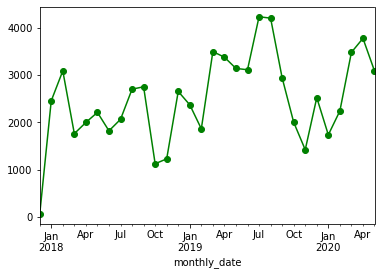

In [3]:
_ = df['requested_qty'].plot(color='green', linestyle="-", marker="o")

### AR, MA and ARMA models

#### AR: Autoregressive part.
- AR(1) model: $y_t = a_1 y_{t-1} + \varepsilon_t$
- AR(p) model: $y_t = a_1 y_{t-1} + a_2 y_{t-2} + \cdots + a_p y_{t-p} + \varepsilon_t$


#### MA: Moving Averages part. 
- MA(1) model: $y_t = m_1 \varepsilon_{t-1} + \varepsilon_t$
- MA(q) model: $y_t = m_1 \varepsilon_{t-1} + m_2 \varepsilon_{t-2} + \cdots + m_q \varepsilon_{t-q} + \varepsilon_t$


#### ARMA: Combine AR and MA. 
- ARMA(1, 1) model: $y_t = a_1 y_{t-1} + m_1 \varepsilon_{t-1} + \varepsilon_t$
- ARMA(p, q) model: $y_t = a_1 y_{t-1} + \cdots + a_p y_{t-p} + m_1 \varepsilon_{t-1} + \cdots + m_q \varepsilon_{t-q} + \varepsilon_t$

### Simulate ARMA data:

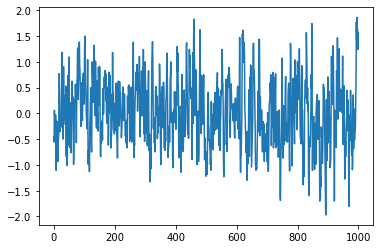

In [4]:
from statsmodels.tsa.arima_process import arma_generate_sample

ar_coefs = [1, -0.5]
ma_coefs = [1, 0.2]
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=1000, scale=0.5)
# This simulates the equation
# y_t + 0.5 y_{t-1} = 0.2 \varepsilon_{t-1} + \varepsilon_t

_ = plt.plot(y)

### Fitting the ARMA model

In [5]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(y, order=(1, 1)) # pandas DataFrame, Series, or numpy array
results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 1)   Log Likelihood                -707.184
Method:                       css-mle   S.D. of innovations              0.491
Date:                Sun, 20 Sep 2020   AIC                           1422.368
Time:                        08:31:03   BIC                           1441.999
Sample:                             0   HQIC                          1429.830
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0172      0.040      0.431      0.667      -0.061       0.095
ar.L1.y        0.5399      0.041     13.068      0.000       0.459       0.621
ma.L1.y        0.1850      0.049      3.789      0.0

### ARMAX model

#### ARMAX = ARMA + X (exogenous input)

- ARMAX(1, 1) model: $y_t = x_1 z_t + a_1 y_{t-1} + m_1 \varepsilon_{t-1} + \varepsilon_t$

### Fitting the ARMAX model:

In [6]:
model = ARMA(df['requested_qty'], order=(2, 1), exog=df['price'])
results = model.fit()
print(results.summary())

/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:          requested_qty   No. Observations:                   30
Model:                     ARMA(2, 1)   Log Likelihood                -240.286
Method:                       css-mle   S.D. of innovations            719.330
Date:                Sun, 20 Sep 2020   AIC                            492.573
Time:                        08:31:04   BIC                            500.980
Sample:                    12-01-2017   HQIC                           495.262
                         - 05-01-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 162.3073   1356.714      0.120      0.905   -2496.804    2821.418
price                1057.8517    618.234      1.711      0.087    -153.865    2269.568
ar.L1.requested_

### Making predictions

In the code below, 
- `order=(1, 0, 1)` is equivalent to ARMA(1, 1)
- `trend='c'` if time series is not centered; `trend='t'` if linearly increasing trend, see [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

- The `.get_prediction()` method returns a `forecast` object that has `predicted_mean` pd.Series object and a `conf_int()` pd.DataFrame method. 

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = SARIMAX(df['requested_qty'], order=(1, 0, 1), trend='c')

results = model.fit()
forecast = results.get_prediction(start=-5, dynamic=True)
    # one can make dynamic predictions with `dynamic=True`

In [8]:
mean_forecast = forecast.predicted_mean
print(mean_forecast)

2020-01-01    2869.566041
2020-02-01    2468.984510
2020-03-01    2440.757784
2020-04-01    2438.768806
2020-05-01    2438.628654
Freq: MS, dtype: float64


In [9]:
confidence_interval = forecast.conf_int()
display(confidence_interval.head())

,lower requested_qty,upper requested_qty
2020-01-01,1399.469702,4339.662380
2020-02-01,601.045326,4336.923694
2020-03-01,571.054416,4310.461153
2020-04-01,569.056682,4308.480930
2020-05-01,568.916487,4308.340821


### Plotting past predictions

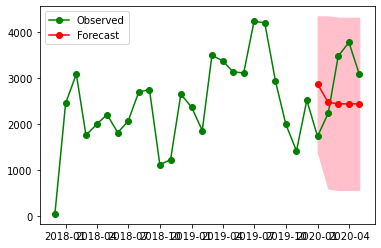

In [10]:
plt.figure()
plt.plot(df.index, df['requested_qty'], color='green', label='Observed', linestyle="-", marker="o")
plt.plot(mean_forecast.index, mean_forecast, color='red', label='Forecast', marker='o')
_ = plt.fill_between(confidence_interval.index, 
                 confidence_interval['lower requested_qty'], 
                 confidence_interval['upper requested_qty'], 
                 color='pink')
_ = plt.legend(loc='upper left')

### Making future forecasts with `get_forecast`

In [11]:
results = model.fit()
forecast = results.get_forecast(steps=5)

mean_forecast = forecast.predicted_mean
print(mean_forecast)

2020-06-01    2447.296135
2020-07-01    2439.229527
2020-08-01    2438.661118
2020-09-01    2438.621066
2020-10-01    2438.618243
Freq: MS, dtype: float64


In [12]:
confidence_interval = forecast.conf_int()
display(confidence_interval)

,lower requested_qty,upper requested_qty
2020-06-01,977.199805,3917.392465
2020-07-01,571.290342,4307.168711
2020-08-01,568.957750,4308.364487
2020-09-01,568.908942,4308.333190
2020-10-01,568.906076,4308.330411


### ARIMA model

#### ARMA = ARMA + I (integral)

- If time series is not stationary, we might need to take the n-th difference to make it stationary. Predictions from such _stationarized_ time series need us to add the offset using `np.cumsum` to get reasonable forecasts. In this case, one uses the ARIMA model that does this time-differencing and integrating internally. 

### Using ACF and PACF to identify the correct model order

- ACF: AutoCorrelation Function 
    - lag-1 ACF $\rightarrow \text{corr}(y_t, y_{t-1})$
    - lag-2 ACF $\rightarrow \text{corr}(y_t, y_{t-2})$
- PACF: Partial AutoCorrelation Function

|      | AR(p)                | MA(q)                | ARMA(p, q) |
|------|----------------------|----------------------|------------|
| ACF  | Tails off            | Curs off after lag q | Tails off  |
| PACF | Cuts off after lag p | Tails off            | Tails off  |

- See also: [here](https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms) and [here](https://otexts.com/fpp2/non-seasonal-arima.html)

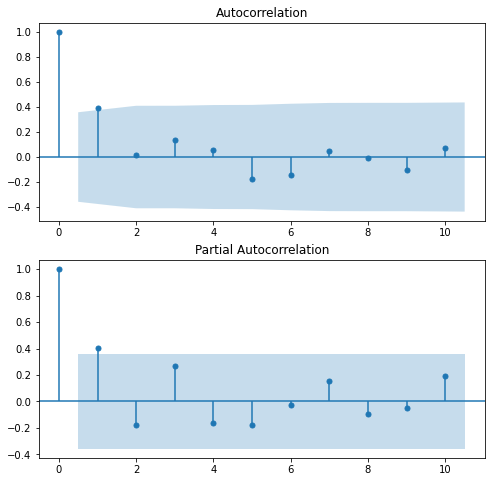

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(df['requested_qty'], lags=10, ax=axs[0])
plot_pacf(df['requested_qty'], lags=10, ax=axs[1])

plt.show()

# We see significant spike in the ACF plot at lag = 1
# and sinusoidal behavior for PACF so use ARMA(0, 1)

### AIC v/s BIC rule of thumb

- Lower the value, better the model
- BIC favors simpler models than AIC
- AIC is better at choosing predictive models
- BIC is better at choosing good explanatory models

In [14]:
p_range = 5; q_range = 5
res = pd.DataFrame(columns=['p', 'q', 'AIC', 'BIC'])
for p in range(p_range):
    for q in range(q_range):
        if p + q == 0: pass
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model = SARIMAX(df['requested_qty'], order=(p, 0, q))
        
        results = model.fit()
        aic = results.aic
        bic = results.bic
        res = res.append({'p':p, 'q':q, 'AIC':aic, 'BIC':bic}, ignore_index=True)
res.head()

/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmode

,p,q,AIC,BIC
0,0.0,0.0,560.269152,561.670349
1,0.0,1.0,529.143586,531.945980
2,0.0,2.0,516.758636,520.962229
3,0.0,3.0,522.805781,528.410570
4,0.0,4.0,508.734819,515.740806


In [15]:
res.sort_values('BIC').head()

,p,q,AIC,BIC
15,3.0,0.0,495.664272,501.269061
7,1.0,2.0,495.674139,501.278929
5,1.0,0.0,499.612165,502.414559
20,4.0,0.0,497.359684,504.365671
16,3.0,1.0,497.424194,504.430181


### Model diagnostics

1. The standard residual ought to be Gaussian noise
2. The histogram should be close to a normal distribution; green and orange lines should be close
3. The blue dots representing quantiles should align with the red line

In [16]:
model = SARIMAX(df['requested_qty'], order=(1, 0, 0))
results = model.fit()

residuals = results.resid
mae = np.mean(np.abs(residuals))

/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/abhishek/miniconda3/envs/basenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


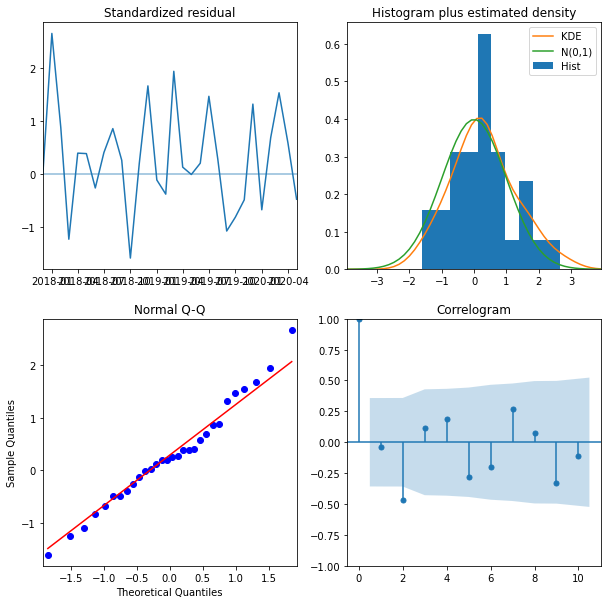

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]
_ = results.plot_diagnostics()
plt.show()

### SARMAX model to analyze Seasonal data


- Repeats after any amount of time
- Made of `trends` + `seasonal component` + `residual`

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_results = seasonal_decompose(df['requested_qty'], freq=12)

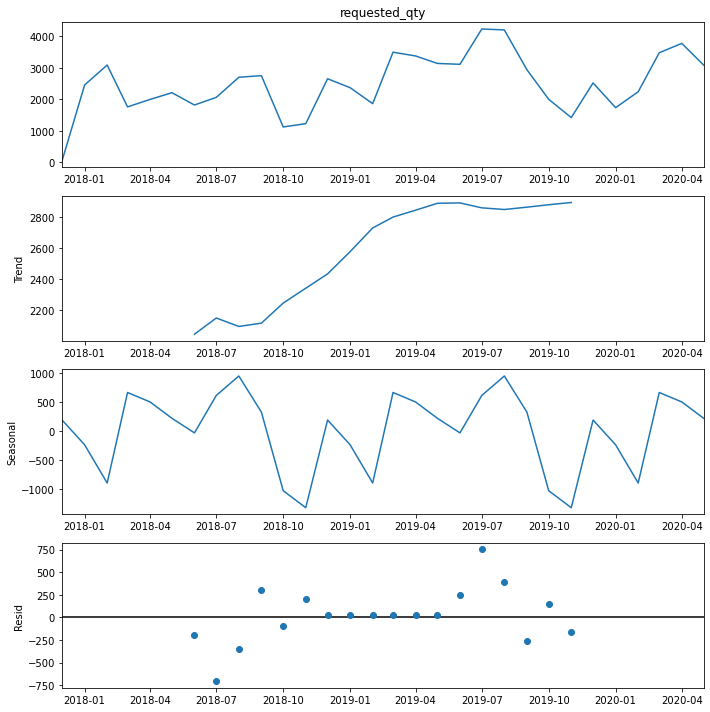

In [19]:
decomp_results.plot()
plt.show()

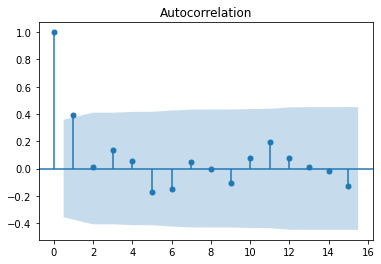

In [20]:
plt.rcParams['figure.figsize'] = [6, 4]
plot_acf(df['requested_qty'])
plt.show()

## Future

### SARIMA = Seasonal ARIMA 

$\text{SARIMA}(p, d, q)(P, D, Q)_S$

- Equivalent to applying two models, one to the seasonal part and another to the non-seasonal. 
- Non-seasonal orders:
    - p: autoregressive order
    - d: differencing order
    - q: moving average order
- Seasonal orders:
    - P: seasonal autoregressive order
    - D: seasonal differencing order
    - Q: seasonal moving average order
    - S: length of seasonal cycle
    
### VARMAX = Vector Autoregression

- Wikipedia article: https://en.wikipedia.org/wiki/Vector_autoregression
- Here the time series is a multivaluled vector
- `statsmodels` implementation: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html